In [1]:
!git clone https://github.com/mohahf19/public-annrl-files.git 
!cp -r public-annrl-files/* .
!rm -r public-annrl-files

Cloning into 'public-annrl-files'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 17 (delta 0), reused 17 (delta 0), pack-reused 0
Unpacking objects: 100% (17/17), 22.56 KiB | 3.76 MiB/s, done.


In [ ]:
# # # Add the parent directory to path
# import sys

# sys.path.append("..")

In [6]:
import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env import Env, Log
from epidemic_env.dynamics import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent import Agent

"""Pytorch and numpy imports"""
import numpy as np
from typing import Callable

from pathlib import Path

import torch
from torch import nn, optim

from tqdm import tqdm
import random
from collections import namedtuple, deque
import json


%matplotlib inline

In [7]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

['Lausanne', 'Geneva', 'Sion', 'Neuchâtel', 'Basel', 'Bern', 'Lücern', 'St-Gallen', 'Zürich']


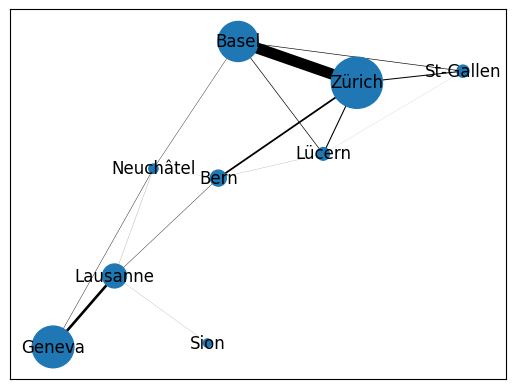

In [9]:
dyn = ModelDynamics("config/switzerland.yaml")  # load the switzerland map
print(dyn.cities)
dyn.draw_map()

In [11]:
from typing import Callable
from copy import deepcopy

action = {  # DO NOTHING
    "confinement": False,
    "isolation": False,
    "hospital": False,
    "vaccinate": False,
}

# Actually, actions can be any combination of the four.
action_value_dict = {0: "confinement", 1: "isolation", 2: "hospital", 3: "vaccinate"}

# num_actions = 2**1  # If only for confinement
num_actions = len(action.keys()) * 2  # Do nothing and toggle 4 actions
num_cities = len(dyn.cities)
num_features_per_city = 2  # infected, dead

num_observation_features = (
    num_cities * (num_features_per_city * 7) 
)  # 4 curr_actions


def observation_to_tensor(
    obs: Observation,
    dyn: ModelDynamics,
    features_per_city: int = 7 * num_features_per_city,
) -> torch.Tensor:
    """Convers the observation object to a torch Tensor
    The tensor is defined as: for each city, population (1), infected (7), dead (7)
    """
    num_cities = len(dyn.cities)
    output = torch.zeros(num_cities * features_per_city)
    for i, city in enumerate(dyn.cities):
        output[i * features_per_city : i * features_per_city + 7] = (
            torch.tensor(obs.city[city].infected) / obs.pop[city]
        ) ** (1 / 4)
        output[i * features_per_city + 7 : i * features_per_city + 14] = (
            torch.tensor(obs.city[city].dead) / obs.pop[city]
        ) ** (1 / 4)

    return output


"""Loading the environment"""
env = Env(
    dyn,  # We pass the dynamical model to the environment
    action_space=spaces.Discrete(
        num_actions
    ),  # Here one could pass an openai gym action space that can then be sampled
    observation_space=spaces.Box(
        low=0, high=np.inf, shape=(num_observation_features,), dtype=float
    ),  # Here one could pass an openai gym obs space that can then be sampled
)



def create_action(
    actions: np.ndarray, # a 4-length array of 1/0, True means take the action, False means do nothing
    action_value_dict: dict = action_value_dict,
) -> dict[str, bool]:
    """Creates a policy from the encoded action value"""
    action_inds = torch.where(actions)[0]
    action = {key: False for key in action_value_dict.values()}
    for ind in action_inds:
        action[action_value_dict[ind.item()]] = True
    return action

t = torch.tensor(np.array([0, 1, 1, 1]))
create_action(t)

{'confinement': False, 'isolation': True, 'hospital': True, 'vaccinate': True}

In [12]:
# Print observation to tensor example
obs, _ = env.reset()
print(obs)
t = observation_to_tensor(obs, dyn)
print(t, t.shape)


Observation(pop={'Lausanne': 295000, 'Geneva': 900000, 'Sion': 34978, 'Neuchâtel': 44531, 'Basel': 830000, 'Bern': 133115, 'Lücern': 82000, 'St-Gallen': 76213, 'Zürich': 1354000}, city={'Lausanne': Observables(infected=[0, 0, 0, 0, 0, 0, 0], dead=[0, 0, 0, 0, 0, 0, 0]), 'Geneva': Observables(infected=[0, 0, 0, 0, 0, 0, 0], dead=[0, 0, 0, 0, 0, 0, 0]), 'Sion': Observables(infected=[20, 32, 31, 141, 40, 173, 47], dead=[0, 0, 0, 0, 0, 0, 1]), 'Neuchâtel': Observables(infected=[0, 0, 0, 0, 0, 0, 0], dead=[0, 0, 0, 0, 0, 0, 0]), 'Basel': Observables(infected=[0, 0, 0, 0, 0, 0, 0], dead=[0, 0, 0, 0, 0, 0, 0]), 'Bern': Observables(infected=[0, 0, 0, 0, 0, 0, 0], dead=[0, 0, 0, 0, 0, 0, 0]), 'Lücern': Observables(infected=[0, 0, 0, 0, 0, 0, 0], dead=[0, 0, 0, 0, 0, 0, 0]), 'St-Gallen': Observables(infected=[0, 0, 0, 0, 0, 0, 0], dead=[0, 0, 0, 0, 0, 0, 0]), 'Zürich': Observables(infected=[0, 0, 0, 0, 0, 0, 0], dead=[0, 0, 0, 0, 0, 0, 0])}, total=Observables(infected=[20, 32, 31, 141, 40, 173, 

In [13]:
import random
from collections import namedtuple, deque

Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))


class ReplayMemory:
    def __init__(self, capacity: int):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, bs: int):
        n_to_sample = bs if bs < len(self.memory) else len(self.memory)
        return random.sample(self.memory, n_to_sample)

    def __len__(self) -> int:
        return len(self.memory)
    
import torch
from torch import nn, optim


class DQNModel(nn.Module):
    def __init__(self, obs_dim: int, actions_dim: int, activation: str = "relu"):
        super().__init__()
        if activation == "relu":
            self.activation = nn.ReLU
        elif activation == "tanh":
            self.activation = nn.Tanh
        else:
            raise ValueError("Activation must be either relu or tanh")

        self.net = nn.Sequential(
            # nn.LayerNorm(obs_dim),
            nn.Linear(obs_dim, 64),
            self.activation(),
            nn.Linear(64, 32),
            self.activation(),
            nn.Linear(32, 16),
            self.activation(),
            nn.Linear(16, actions_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


# Adapt this
dqn = DQNModel(env.observation_space.shape[0], num_actions, activation="relu")
obs = torch.randn(10, env.observation_space.shape[0])
output = dqn(obs)
print(output)



tensor([[-0.1146, -0.2858, -0.2029, -0.1301,  0.1386,  0.2874, -0.1286,  0.0435],
        [-0.1635, -0.2715, -0.2312, -0.1110,  0.1501,  0.2553, -0.1341,  0.0171],
        [-0.1346, -0.2803, -0.2264, -0.1305,  0.1347,  0.3120, -0.1566,  0.0231],
        [-0.1293, -0.3055, -0.2018, -0.1369,  0.1446,  0.2723, -0.1170,  0.0373],
        [-0.1353, -0.2938, -0.1939, -0.0713,  0.1585,  0.2592, -0.1287,  0.0635],
        [-0.1091, -0.2713, -0.2277, -0.1433,  0.1648,  0.3372, -0.1427,  0.0463],
        [-0.0835, -0.2615, -0.2057, -0.1355,  0.1439,  0.3268, -0.1404,  0.0595],
        [-0.1646, -0.2685, -0.2090, -0.0922,  0.1081,  0.2612, -0.1437,  0.0091],
        [-0.1163, -0.2911, -0.2182, -0.0728,  0.1820,  0.2700, -0.1156,  0.0585],
        [-0.1184, -0.2888, -0.2184, -0.1314,  0.1520,  0.2893, -0.1347,  0.0445]],
       grad_fn=<AddmmBackward0>)


In [14]:
def select_action(output: torch.Tensor, epsilon: float, device: str = "cpu") -> int:
    """Selects an action based on the output of the DQN."""
    if np.random.rand() < epsilon:
        return torch.tensor(np.random.randint(0, 2, size=(4,))).to(device)
    else:
        t = output.reshape(-1, 2)
        return torch.argmax(t, dim=1).to(device)


In [15]:
t = torch.tensor((np.random.randn(num_actions) * 100).astype(int))
print(t)
print(t.reshape(-1, 2))


print("epsilon 0:", select_action(t, 0), create_action(select_action(t, 0)))
print("epsilon 1:", a:=select_action(t, 1), create_action(a))
print("epsilon 1:", a:=select_action(t, 1), create_action(a))

tensor([ -19, -129,  -86,    0,  -41,   23,  -94,  -31])
tensor([[ -19, -129],
        [ -86,    0],
        [ -41,   23],
        [ -94,  -31]])
epsilon 0: tensor([0, 1, 1, 1]) {'confinement': False, 'isolation': True, 'hospital': True, 'vaccinate': True}
epsilon 1: tensor([0, 0, 1, 1]) {'confinement': False, 'isolation': False, 'hospital': True, 'vaccinate': True}
epsilon 1: tensor([1, 0, 1, 1]) {'confinement': True, 'isolation': False, 'hospital': True, 'vaccinate': True}


In [36]:
def simulate_policy(
        policy_net: nn.Module,
        eval_seed_sequences: np.ndarray,
        discount_factor: float,
        device: str,
        logging: bool = False,
) -> list[float]:
    rewards = []
    policy_net.eval()
    print_pol = True

    for eval_seed in eval_seed_sequences:
        cumulative_reward = 0
        curr_discount_factor = 1
        done = False
        obs, info = env.reset(seed=eval_seed)
        obs_tensor = observation_to_tensor(obs, dyn).to(device)
        policy_net.to(device)

        while not done:
            policy_output = policy_net(obs_tensor)
            if print_pol:
                print(f'pol_output in simulate = \n{policy_output.cpu().detach().reshape(-1, 4).numpy()}')
                print_pol = False
            action = select_action(policy_output, epsilon=0, device=device)
            curr_action = create_action(action)
            obs, reward, done, info = env.step(curr_action)
            obs_tensor = observation_to_tensor(obs, dyn).to(device)
            if logging:
                # print(f"{action} ({reward.item():.2f})", end=" ")
                print(list(np.where(action.cpu().numpy())[0]), end=", ")
            reward = reward.to(device)

            cumulative_reward += curr_discount_factor * reward
            curr_discount_factor *= discount_factor
        rewards.append(cumulative_reward.item())
        if logging:
            print(f" -> reward: {cumulative_reward.item():.3f}")
            print(info.total)
            print()
    policy_net.train()

    return rewards

In [17]:
def optimize_model(
    policy_net: nn.Module,
    target_net: nn.Module,
    memory: ReplayMemory,
    optimizer: torch.optim,
    batch_size: int,
    discount_factor: float,
    scheduler: optim.lr_scheduler = None,
    device: str = "cpu",
) -> None:
    """Optimizes the policy network based on a batch of transitions sampled from the replay memory. Only optmise if the replay memory is larger than the batch size."""
    # assert batch_size <= len(memory), "Insufficient memory to sample a batch."

    def criterion(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return torch.nn.MSELoss()(x, y) / (2 * len(x))
        # return torch.nn.SmoothL1Loss()(x, y) / (len(x))

    transitions = memory.sample(batch_size)

    """ChatGPT Explanation:
    The code batch = Transition(*zip(*transitions)) takes the list of transitions transitions and converts it into a batch of transitions, where each element of the batch is a tuple containing the corresponding elements from all transitions.

    Let's break down the code:

    zip(*transitions) takes all the transitions and groups together all elements at the same position in each tuple, effectively transposing the list of tuples. For example, if the original transitions list contains (s1, a1, s2, r1) and (s2, a2, s3, r2), the result of zip(*transitions) will be (s1, s2), (a1, a2), (s2, s3), (r1, r2).

    * before zip unpacks the list transitions into separate arguments to zip.

    Transition(*zip(*transitions)) uses argument unpacking again, but this time for the Transition namedtuple. It unpacks the resulting tuples of zip(*transitions) into four separate arguments (state, action, next_state, reward) and creates a new instance of Transition for each element in the batch.

    So, batch is a namedtuple of batches, where each element in the batch corresponds to all states, actions, next_states and rewards from all the transitions. For example, if the original transitions list contains three transitions, then batch.state would be a tuple of the three states, batch.action would be a tuple of the three actions, and so on.
    """
    batch = Transition(*zip(*transitions))

    state_b = torch.stack(batch.state).to(device)
    next_state_b = torch.stack(batch.next_state).to(device)
    action_b = torch.stack(batch.action).to(device)
    reward_b = torch.tensor(batch.reward).to(device)

    policy_net.to(device)
    target_net.to(device)

    # Computes Q_theta(s_t, a_t)
    # Compute Q_theta(s_t, a_t) using action_b
    action_offset_indices = torch.tensor(np.arange(0, 4) * 2).to(device)
    indices = action_b + action_offset_indices
    state_action_values = torch.sum(torch.gather(policy_net(state_b), dim=1, index=indices), axis=1)
    
    
    # Computes \hat{Q}(s_t+1)
    next_state_values = target_net(next_state_b)
    next_state_actions = select_action(next_state_values, 0, device=device).reshape(-1, 4)
    indices = next_state_actions + action_offset_indices
    next_state_action_values = torch.sum(torch.gather(next_state_values, dim=1, index=indices), axis=1)

    # Compute the expected Q values
    expected_state_action_values = (next_state_action_values * discount_factor) + reward_b

    loss = criterion(
        expected_state_action_values, state_action_values.squeeze()
    )  # Difference between the expected Q values and the actual Q values
    # loss = expected_state_action_values - state_action_values.squeeze() # Difference between the expected Q values and the actual Q values

    # Optimize the model now
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if scheduler is not None:
        scheduler.step()

    return loss.item()


def compute_epsilon(
    e_initial: float, e_min: float, total_steps: int, current_steps: int
) -> float:
    return max(e_min, e_initial * (total_steps - current_steps) / total_steps)


In [18]:
policy_net = DQNModel(126, 8)
t = torch.randn(3, 126) * 1000
output = policy_net(t)
print(output, output.shape)
action = select_action(output, 0)
print(action)
action = action.reshape(-1, 4)

print(action)
action_offset_indices = np.arange(0, 4) * 2
indices = action + action_offset_indices
print(torch.gather(output, dim=1, index=indices))
print()


tensor([[ -59.0035,   69.8656,  -25.6638,  162.4766,  119.3043, -185.0172,
          -32.2313,   31.2798],
        [ -43.3248,   13.7638,   -4.1749,   84.7948,   63.9818,  -66.4952,
           -8.0745,  -12.8175],
        [ -80.6358,    1.4914,  -35.8799,  151.9377,   82.7990, -101.4799,
          -36.8377,   65.4003]], grad_fn=<AddmmBackward0>) torch.Size([3, 8])
tensor([1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1])
tensor([[1, 1, 0, 1],
        [1, 1, 0, 0],
        [1, 1, 0, 1]])
tensor([[ 69.8656, 162.4766, 119.3043,  31.2798],
        [ 13.7638,  84.7948,  63.9818,  -8.0745],
        [  1.4914, 151.9377,  82.7990,  65.4003]], grad_fn=<GatherBackward0>)



In [19]:
# def set_new_learning_rate(optimizer, learning_rate, num_episode, compute_new_learning_rate):
#     new_learning_rate = compute_new_learning_rate(num_episode)
#     for param_group in optimizer.param_groups:
#         param_group['lr'] = new_learning_rate
#     return new_learning_rate
        
def run_train_experiment(load_cache, num_episodes, seed, learning_rate, compute_new_learning_rate, 
                         discount_factor, target_update_per, evaluate_per, eval_seed_sequences, 
                         batch_size, buffer_size, epsilon_min, epsilon_init, device, 
                         run_id):
    torch.manual_seed(seed)
    np.random.seed(seed)
    num_eval_episodes = len(eval_seed_sequences)
    env_seed_sequences = np.random.randint(0, 1000, size=num_episodes)

    assert len(env_seed_sequences) == num_episodes


    ## Initializations
    obs, info = env.reset(seed=seed)
    n_actions = env.action_space.n
    n_observations = observation_to_tensor(obs, dyn).shape[0]


    model_save_path = Path("models")
    model_save_path.mkdir(exist_ok=True)
    best_model_path = model_save_path / f"dqn_{run_id}_best.pt"


    ## Policy and target networks
    if load_cache:
        print("Loading from cache")
        policy_net = DQNModel(n_observations, n_actions).to(device)
        policy_net.load_state_dict(torch.load(best_model_path))
        target_net = DQNModel(n_observations, n_actions).to(device)
        target_net.load_state_dict(policy_net.state_dict())
    else:
        print("Creating new models..")
        policy_net = DQNModel(n_observations, n_actions).to(device)
        target_net = DQNModel(n_observations, n_actions).to(device)
        target_net.load_state_dict(policy_net.state_dict())

    memory = ReplayMemory(buffer_size)
    # optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    optimizer = optim.AdamW(policy_net.parameters(), lr = learning_rate)
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    scheduler = None

    tr_losses = []
    learning_rates = []

    tr_trace, eval_trace_mean, eval_trace_std = [], [], []
    has_logged_started_training_message = False

    best_eval_reward = -np.inf


    for num_episode in range(num_episodes):
        # lr = set_new_learning_rate(optimizer, learning_rate, num_episode, compute_new_learning_rate)
        lr = learning_rate
        obs, info = env.reset(seed=env_seed_sequences[num_episode])
        curr_action = {
            "confinement": False,
            "isolation": False,
            "hospital": False,
            "vaccinate": False,
        }
        obs_tensor = observation_to_tensor(obs, dyn).to(device)

        done = False

        cumulative_tr_reward = 0
        curr_discount_factor = 1
        ep_losses = []

        # print_week = True

        while not done:  # play the episode
            policy_output = policy_net(obs_tensor)
            # if print_week:
            #     print(f'pol_output = {policy_output}')
            #     print_week = False
            action = select_action(
                policy_output,
                epsilon=compute_epsilon(
                    epsilon_init, epsilon_min, num_episodes, num_episode
                ),
                device=device,
            )

            curr_action = create_action(action)

            obs, reward, done, info = env.step(curr_action)
            new_obs_tensor = observation_to_tensor(obs, dyn).to(device)
            reward = reward.to(device)

            memory.push(obs_tensor, action, new_obs_tensor, reward)
            obs_tensor = new_obs_tensor

            cumulative_tr_reward += curr_discount_factor * reward
            curr_discount_factor *= discount_factor

            if batch_size <= len(memory):
                if not has_logged_started_training_message:
                    print("Started training")
                    has_logged_started_training_message = True

                loss_val = optimize_model(
                    policy_net,
                    target_net,
                    memory,
                    optimizer,
                    batch_size,
                    discount_factor,
                    device=device,
                    scheduler=scheduler,
                )
                tr_losses.append(loss_val)
                ep_losses.append(loss_val)
                learning_rates.append(lr)
                # print(loss_val)

            # loss_val = optimize_model(policy_net, target_net, memory, optimizer, batch_size, discount_factor, device=device)
            # tr_losses.append(loss_val)
        tr_trace.append(cumulative_tr_reward.item())
        print(f"Episode {num_episode} | Reward: {cumulative_tr_reward.item():.2f} | Mean loss: {np.mean(ep_losses):.5f}, learning rate: {optimizer.param_groups[0]['lr']:1.1e}")

        if num_episode % target_update_per == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if num_episode % evaluate_per == 0 or num_episode == num_episodes - 1:
            eval_rewards = simulate_policy(
                policy_net,
                eval_seed_sequences,
                discount_factor=discount_factor,
                device=device,
            )  # one reward per eval episode, so a 20 length list
            eval_trace_mean.append(np.mean(eval_rewards))
            eval_trace_std.append(np.std(eval_rewards))
            print(
                f"Episode {num_episode} | Eval reward mean: {np.mean(eval_rewards):.2f} | Eval reward std: {np.std(eval_rewards):.5}"
            )

            if np.mean(eval_rewards) >= best_eval_reward:
                # update the best reward and save the model
                print(f"Saved best model 😏")
                best_eval_reward = np.mean(eval_rewards)
                torch.save(policy_net.state_dict(), best_model_path)
    metrics_path = model_save_path / f"dqn_{run_id}_metrics.json"
    with open(metrics_path, "w") as f:
        json.dump({"tr_trace":tr_trace, "eval_trace_mean": eval_trace_mean,
                   "eval_trace_std":eval_trace_std, "tr_losses":tr_losses,
                   "eval_seed_sequences": eval_seed_sequences,
                   "learning_rates": learning_rates},
                  f,
                  cls=NpEncoder)
    return policy_net, tr_trace, eval_trace_mean, tr_losses, learning_rates

In [ ]:
run_ids = [(1, "q4b_1"), (2, "q4b_2"), (3, "q4b_3")]

load_cache = False
num_episodes = 600

first_learning_rate = 1e-3

def compute_new_learning_rate(num_episode):
    # if num_episode < 200:
    #     return 5e-2
    # elif num_episode < 300:
    #     return 1e-3
    # elif num_episode < 450:
    #     return 1e-4
    # else:
    #     return 1e-5
    return first_learning_rate

discount_factor = 0.9
target_update_per = 5  # update target network every 5 episodes
evaluate_per = 20  # evaluate every 20 episodes
num_eval_episodes = 20
batch_size = 2 ** 11
buffer_size  = 20_000
epsilon_min = 0.2
epsilon_init = 0.7
device = "cuda"

run_data = {}
for run_id, run_name in run_ids:
    print(f"Working on run_id = {run_id}")
    seed = 41 + run_id
    np.random.seed(seed)
    eval_seed_sequences = np.random.randint(0, 1000, size=num_eval_episodes)

    policy_net, tr_trace, eval_trace_mean, tr_losses, learning_rates = run_train_experiment(load_cache, num_episodes, 
                                                            seed, first_learning_rate, compute_new_learning_rate,
                                                            discount_factor, 
                                                            target_update_per, evaluate_per, 
                                                            eval_seed_sequences, batch_size, buffer_size, 
                                                            epsilon_min, epsilon_init, device, run_name)
    run_data[run_id] = (policy_net, tr_trace, eval_trace_mean, tr_losses,eval_seed_sequences, learning_rates)


Working on run_id = 1
Creating new models..


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 0 | Reward: -30.01 | Mean loss: nan, learning rate: 1.0e-03
pol_output in simulate = 
[[-0.11103629  0.17054296 -0.05557049  0.2595691 ]
 [ 0.02688873  0.01686414 -0.16559821 -0.0962263 ]]
Episode 0 | Eval reward mean: -9.90 | Eval reward std: 0.9481
Saved best model 😏
Episode 1 | Reward: -32.38 | Mean loss: nan, learning rate: 1.0e-03
Episode 2 | Reward: -53.47 | Mean loss: nan, learning rate: 1.0e-03
Episode 3 | Reward: -31.54 | Mean loss: nan, learning rate: 1.0e-03
Episode 4 | Reward: -29.90 | Mean loss: nan, learning rate: 1.0e-03
Episode 5 | Reward: -14.91 | Mean loss: nan, learning rate: 1.0e-03
Episode 6 | Reward: -30.92 | Mean loss: nan, learning rate: 1.0e-03
Episode 7 | Reward: -63.02 | Mean loss: nan, learning rate: 1.0e-03
Episode 8 | Reward: -29.79 | Mean loss: nan, learning rate: 1.0e-03
Episode 9 | Reward: -25.62 | Mean loss: nan, learning rate: 1.0e-03
Episode 10 | Reward: -94.94 | Mean loss: nan, learning rate: 1.0e-03
Episode 11 | Reward: -64.05 | Mean loss: 

In [22]:
policy_net, tr_trace, eval_trace_mean, tr_losses,eval_seed_sequences, learning_rates = run_data[1]

Text(0.5, 0.98, 'DQN rewards')

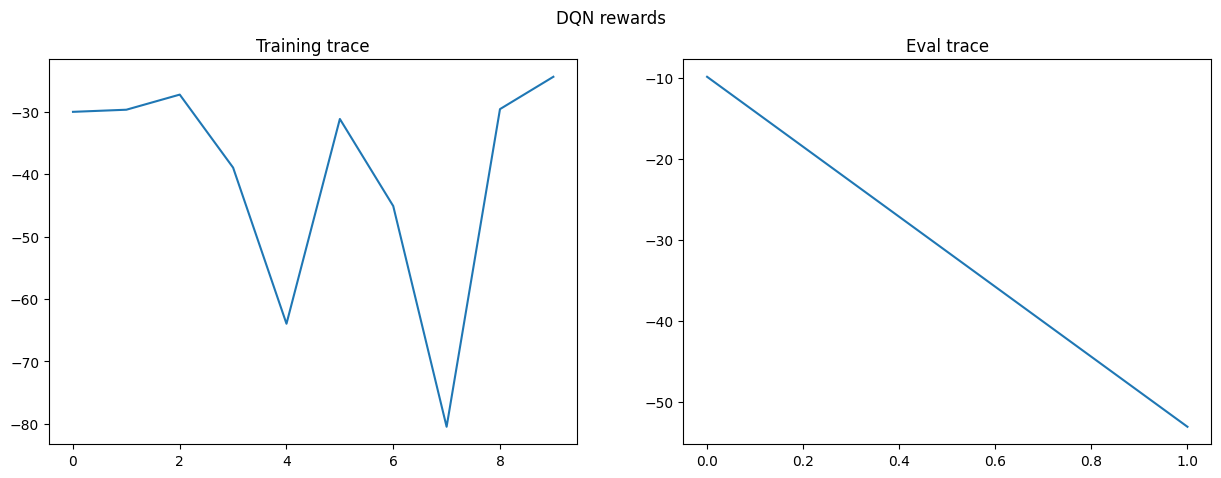

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(tr_trace, label="training rewards")
ax[0].set_title("Training trace")

ax[1].plot(eval_trace_mean, label="eval mean reward")
ax[1].set_title("Eval trace")

fig.suptitle("DQN rewards")

Text(0.5, 0.98, 'Training loss and learning rates')

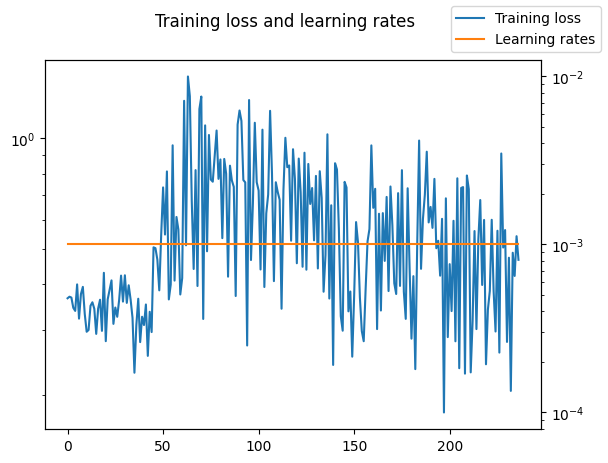

In [24]:
fig, ax = plt.subplots()


ax.plot(tr_losses, label="Training loss", color="tab:blue")
ax.set_yscale("log")


ax2 = ax.twinx()
ax2.plot(learning_rates,  label = "Learning rates", color="tab:orange")
ax2.set_yscale("log")

fig.legend()
fig.suptitle("Training loss and learning rates")

In [37]:
print("1 means confine, 0 means no action")
eval_rewards = simulate_policy(policy_net, eval_seed_sequences, discount_factor=discount_factor, device=device, logging=True)
print(eval_rewards)

1 means confine, 0 means no action
pol_output in simulate = 
[[ 0.29508057 -1.150806   -0.22515824 -0.70566934]
 [-1.2992268  -0.32043007 -0.12709422 -1.1401215 ]]
[2], [2], [2], [2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2],  -> reward: -55.783
Parameters(day=210, suceptible=334321, exposed=0, infected=0, recovered=3387195, dead=63708, initial_population=3749837)

[1, 2], [1, 2], [0, 1, 2], [1, 2], [1, 2], [1, 2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2],  -> reward: -65.938
Parameters(day=210, suceptible=348260, exposed=0, infected=0, recovered=3388147, dead=63676, initial_population=3749837)

[2], [2], [2], [2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2], [2],  -> reward: -54.049
Parameters(day=210, suceptible=

In [ ]:
import pickle

with open("models/data.pkl", "wb") as f:
    pickle.dump(run_data, f)

In [ ]:
!zip -r /content/models /content/models

In [ ]:
from google.colab import files
files.download("/content/models.zip")